# Predicting Defult Loan of Czech Bank (Modeling)


#### Dataset taken from
https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions


### Instructions from 
https://webpages.uncc.edu/mirsad/itcs6265/group1/domain.html
https://webpages.uncc.edu/mirsad/itcs6265/group1/table01_methodology.html

<img src="czeck_bank.png">

### How to connect PostgreSQL to Python
https://towardsdatascience.com/python-and-postgresql-how-to-access-a-postgresql-database-like-a-data-scientist-b5a9c5a0ea43

https://www.datacamp.com/community/tutorials/tutorial-postgresql-python



In [1]:
# !pip install psycopg2

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,   roc_curve, plot_confusion_matrix,confusion_matrix, plot_roc_curve, f1_score, accuracy_score, classification_report

import imblearn
from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek

import psycopg2
import psycopg2.extras


plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [3]:
#stopping warnings
import warnings
with warnings.catch_warnings():

    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

	

In [4]:
DB_HOST = "localhost"
DB_NAME = "czech_bank_trans"
DB_USER = "postgres"
DB_PASS = "3822"

In [5]:
def create_df_from_db(schema, table):
    # Establish the connection with db
    conn = psycopg2.connect(dbname=DB_NAME, 
            user=DB_USER, 
            password=DB_PASS, 
            host=DB_HOST)

    #write the sql command
    sql_command = 'select {} from {}'.format(str(schema), str(table))
    #print('Executint this command ', sql_command)
    #load it to pandas
    df = pd.read_sql(sql_command, conn)
    
    # df_summary(df)
    conn.close()
    return df

def create_all_dbs(lst):
    #calling all tables from db
    df_names = []
    for name in lst:
        df = 'df' + 'name'
        print('************{} has been created********' .format(name))
        df  = create_df_from_db('*', name)
        df_names.append(df )
    print('*'* 50)
    print('Total No. of df created', len(df_names))
    return df_names

def df_summary(df):
    # print('**************',df,'**************')
    print(f" df has a shape of {df.shape}")
    print(df.info())
    print(df.head())
    print('*' * 50)


In [6]:
#load all the tables from SQL to pandas

schemas = ['account', 'card', 'client', 'disp', 'district', 'loan', 'orders', 'trans']
#df_all = 'df_account, df_card, df_client, df_disp, df_district, df_loan, df_orders, df_trans'

df_account, df_card, df_client, df_disp, df_district, df_loan, df_orders, df_trans = create_all_dbs(schemas)


************account has been created********
************card has been created********
************client has been created********
************disp has been created********
************district has been created********
************loan has been created********
************orders has been created********
************trans has been created********
**************************************************
Total No. of df created 8


In [7]:

file_dir = 'data'
for dirpath, dirnames, files in os.walk(file_dir):
    print(files)


['loan.csv', 'orders.csv', '.DS_Store', 'client.csv', 'district.csv', 'trans.csv', 'account.csv', 'card.csv', 'disp.csv']


### Cleaning Up the dfs

In [8]:
df_disp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


In [9]:
# cleaning up all datasets

# clean up loan
df_loan['duration'].astype(object) # changing loan to object type as there are 5 types.
df_loan['loan_defaulted'] = 0
df_loan['loan_defaulted'] = (df_loan['status'] == 'B') | (df_loan['status'] == 'D')
df_loan['loan_defaulted'] = df_loan['loan_defaulted'].astype(int)
df_loan.rename(columns= {'date': 'loan_date',  'amount': 'loan_amount', 'duration': 'loan_duration', 'payment': 'laon_payment'}, inplace=True)

#clean up order
df_orders['k_symbol'].replace('SIPO', 'household', inplace = True)
df_orders['k_symbol'].replace('UVER', 'loan_payment', inplace = True)
df_orders['k_symbol'].replace('LEASING', 'leasing', inplace = True)
df_orders['k_symbol'].replace('POJISTNE', 'ins_payment', inplace = True)
df_orders.rename(columns= {'k_symbol' : 'category'}, inplace=True)

# clean up trans
df_trans.rename(columns= {'date': 'trans_date', 'type': 'trans_type', 'amount': 'trans_amount', 'balance': 'trans_balance'}, inplace = True)
df_trans['trans_type'].replace('PRIJEM', ' credit', inplace= True)
df_trans['trans_type'].replace('VYDAJ', ' withdrawal', inplace= True)
df_trans['operation'].replace('VYBER KARTOU', ' cre_card_withdrawal', inplace= True)
df_trans['operation'].replace('VKLAD', ' cred_in_cash', inplace= True)
df_trans['operation'].replace('PREVOD Z UCTU', ' collection_bank', inplace= True)
df_trans['operation'].replace('VYBER ', ' cash_withdrawal', inplace= True)
df_trans['operation'].replace('PREVOD NA UCET', ' remit_to_bank', inplace= True)

df_trans['k_symbol'].replace('POJISTNE', 'ins_payment', inplace = True)
df_trans['k_symbol'].replace('SLUZBY', 'payment_statement', inplace = True)
df_trans['k_symbol'].replace('UROK', 'int_credited', inplace = True)
df_trans['k_symbol'].replace('SANKC. UROK', 'sanc_int', inplace = True)
df_trans['k_symbol'].replace('SIPO', 'household', inplace = True)
df_trans['k_symbol'].replace('DUCHOD', 'pension', inplace = True)
df_trans['k_symbol'].replace('UVER', 'loan_payment', inplace = True)
df_trans.rename(columns = {'k_symbol' : 'category', 'type': 'trans_type'}, inplace=True)

# df_account clean up
df_account['frequency'].replace('POPLATEK MESICNE', 'monthly', inplace=True)
df_account['frequency'].replace('POPLATEK TYDNE', 'weekly', inplace=True)
df_account['frequency'].replace('POPLATEK PO OBRATU', 'after_trans', inplace=True)
df_account.rename(columns= {'date': 'acc_date', 'frequency': 'acc_freq'}, inplace=True)


# df_card
df_card.rename(columns= {'issued' : 'card_date', 'type': 'card_type'}, inplace = True)

# df_disp
df_disp['type'].replace('OWNER', 'owner', inplace= True)
df_disp['type'].replace('DISPONENT', 'disponent', inplace= True)
df_disp.rename(columns= {'type': 'disp_type'}, inplace=True)

#df_district
df_district['n_crime'] = (df_district['a15'] + df_district['a16']) # average of 95 and 96
df_district['n_unempl'] = df_district['a4']*(df_district['a12']/100 + df_district['a13']/100)/2 # average of 95 and 96 * n_inhibits
df_district.rename(columns = {'a2': 'district_name', 'a3': 'region', 'a4': 'n_inhibits', 'a11': 'avg_salary', 'a14': 'no_enterpreneurs'}, inplace= True)

print('Cleaned')


Cleaned


In [10]:
df_account.head()

,account_id,district_id,acc_freq,acc_date
0,576,55,monthly,1993-01-01
1,3818,74,monthly,1993-01-01
2,704,55,monthly,1993-01-01
3,2378,16,monthly,1993-01-01
4,2632,24,monthly,1993-01-02


In [11]:
df_client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [12]:
'''
df_client -
Analysis suggests that the format is as follows:
  - YYMMDD
    (Men)

  - YY50+MMDD
    (Women)

'''
# print(df_client['birth_number'][0] )  # 706213
# print(df_client['birth_number'][0] // 100) #  7062
# print(df_client['birth_number'][0] )  # 706213
# print( 100 *(df_client['birth_number'][0] // 
# 10000)) # 7000
# print((df_client['birth_number'][0] // 100) - ( 100 *(df_client['birth_number'][0] // 
# 10000))) # 62

df_client['temp_sex'] = (df_client['birth_number'] // 100) - ( 100 *(df_client['birth_number'] // 10000))

#if this number is greater than 50, it is Female
#https://datatofish.com/if-condition-in-pandas-dataframe/
df_client.loc[df_client['temp_sex'] > 50, 'sex'] = 'F'
df_client.loc[df_client['temp_sex'] <= 50, 'sex'] = 'M'
# remove temp column
df_client.drop('temp_sex', axis =1, inplace= True)
# decrease birth number by 50000 and change to datetime
df_client.loc[df_client['sex'] == 'F', 'birth_number'] -=  5000 # decrease birth_number by 5000

# change birth_number to datetime

df_client['birth_number'] = pd.to_datetime(df_client['birth_number']+19000000, format='%Y%m%d')

df_client.rename(columns= {'birth_number': 'date_of_birth'}, inplace= True)

# change date of birth to age

def dob_age(born):
    today = datetime.today()
    return today.year - born.year

df_client['age'] = df_client['date_of_birth'].apply(lambda x: dob_age(x))
df_client['age'] = df_client['age'].astype(np.float64)

# bin the age into youth(0-24), adult(25-44), middle_age(45-64), senior(65+)
#https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas/45273750

age_labels = ['youth', 'adult', 'middle_age', 'senior']
bins = [0, 25, 45, 65, 100]
df_client['age_group'] = pd.cut(df_client['age'], bins= bins, labels=age_labels)

df_client.head()


,client_id,date_of_birth,district_id,sex,age,age_group
0,1,1970-12-13,18,F,51.0,middle_age
1,2,1945-02-04,1,M,76.0,senior
2,3,1940-10-09,1,F,81.0,senior
3,4,1956-12-01,5,M,65.0,middle_age
4,5,1960-07-03,5,F,61.0,middle_age


### Merging all and creating a new df_all

In [13]:
# merge df_loan with df_account
df_all = pd.merge(df_loan, df_account, on= 'account_id', how= 'outer')

#merge df_all with df_district
df_all = pd.merge(df_all, df_district, on= 'district_id', how='left')

# merge df_lla with disp
df_all = pd.merge(df_all, df_disp, on='account_id', how='outer')

# merge df_all with client
df_all = pd.merge(df_all, df_client, on='client_id', how='outer')

# merge df_all with card
df_all = pd.merge(df_all, df_card, on='disp_id', how='outer')

# keeping only valid loan_id and removing everything else
#https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
df_all = df_all[df_all['loan_id'].notnull()]


# getting average tran_amount, trans_balance 

df_temp = df_trans.groupby('account_id').mean()
df_temp = df_temp[['trans_amount', 'trans_balance']]
df_temp.rename(columns={'trans_amount': 'avg_trans_amount', 'trans_balance': 'avg_trans_balance'}, inplace=True)

df_all['duration_acc_loan'] = df_all['loan_date'] - df_all['acc_date']

# change this ns to days
#https://stackoverflow.com/questions/13703720/converting-between-datetime-timestamp-and-datetime64

df_all['duration_acc_loan'] = df_all['duration_acc_loan'].astype(np.int64) / (24*60*60* 10**9) # hr,min,sec,ns

df_all = df_all.join(df_temp)


In [14]:
print(df_all.shape,df_loan.shape, df_account.shape, df_district.shape, df_disp.shape, df_client.shape, df_card.shape)
df_all.head()

(827, 42) (682, 8) (4500, 4) (77, 18) (5369, 4) (5369, 6) (892, 4)


,loan_id,account_id,loan_date,loan_amount,loan_duration,laon_payment,status,loan_defaulted,district_id_x,acc_freq,acc_date,district_name,region,n_inhibits,a5,a6,a7,a8,a9,a10,avg_salary,a12,a13,no_enterpreneurs,a15,a16,n_crime,n_unempl,disp_id,client_id,disp_type,date_of_birth,district_id_y,sex,age,age_group,card_id,card_type,card_date,duration_acc_loan,avg_trans_amount,avg_trans_balance
0,5314.0,1787,1993-07-05,96396.0,12.0,8033.0,B,1.0,30,weekly,1993-03-22,Sokolov,west Bohemia,94812.0,15.0,13.0,8.0,2.0,10.0,81.8,9650.0,3.38,3.67,100.0,2985.0,2804.0,5789.0,3342.12300,2166,2166,owner,1947-07-22,30,F,74.0,senior,NaN,NaN,NaT,105.0,NaN,NaN
1,5316.0,1801,1993-07-11,165960.0,36.0,4610.0,A,0.0,46,monthly,1993-02-13,Nachod,east Bohemia,112709.0,48.0,20.0,7.0,3.0,10.0,73.5,8369.0,1.79,2.31,117.0,2854.0,2618.0,5472.0,2310.53450,2181,2181,owner,1968-07-22,46,M,53.0,middle_age,NaN,NaN,NaT,148.0,1569.767782,15994.008368
2,6863.0,9188,1993-07-28,127080.0,60.0,2118.0,A,0.0,45,monthly,1993-02-08,Jicin,east Bohemia,77917.0,85.0,19.0,6.0,1.0,5.0,53.5,8390.0,2.28,2.89,132.0,2080.0,2122.0,4202.0,2014.15445,11006,11314,owner,1936-06-02,45,M,85.0,senior,NaN,NaN,NaT,170.0,6593.052929,36540.704393
3,5325.0,1843,1993-08-03,105804.0,36.0,2939.0,A,0.0,12,monthly,1993-01-30,Pribram,central Bohemia,107870.0,84.0,29.0,6.0,1.0,6.0,58.0,8754.0,3.83,4.31,137.0,3804.0,3868.0,7672.0,4390.30900,2235,2235,owner,1940-04-20,14,F,81.0,senior,352.0,classic,1998-09-11,185.0,2521.553846,26973.506838
4,7240.0,11013,1993-09-06,274740.0,60.0,4579.0,A,0.0,1,weekly,1993-02-14,Hl.m. Praha,Prague,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,12541.0,0.29,0.43,167.0,85677.0,99107.0,184784.0,4337.83080,13231,13539,owner,1978-09-07,63,M,43.0,adult,1223.0,junior,1995-05-02,204.0,1886.943011,21753.446237


In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827 entries, 0 to 826
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   loan_id            827 non-null    float64       
 1   account_id         827 non-null    int64         
 2   loan_date          827 non-null    datetime64[ns]
 3   loan_amount        827 non-null    float64       
 4   loan_duration      827 non-null    float64       
 5   laon_payment       827 non-null    float64       
 6   status             827 non-null    object        
 7   loan_defaulted     827 non-null    float64       
 8   district_id_x      827 non-null    int64         
 9   acc_freq           827 non-null    object        
 10  acc_date           827 non-null    datetime64[ns]
 11  district_name      827 non-null    object        
 12  region             827 non-null    object        
 13  n_inhibits         827 non-null    float64       
 14  a5        

In [16]:
df_temp = df_all.copy()
df_temp = pd.get_dummies(df_temp, columns=['sex', 'card_type', 'disp_type', 'district_name'], prefix=['sex', 'card_type', 'disp_type','district_name'])
df_temp.head(10)

,loan_id,account_id,loan_date,loan_amount,loan_duration,laon_payment,status,loan_defaulted,district_id_x,acc_freq,acc_date,region,n_inhibits,a5,a6,a7,a8,a9,a10,avg_salary,a12,a13,no_enterpreneurs,a15,a16,n_crime,n_unempl,disp_id,client_id,date_of_birth,district_id_y,age,age_group,card_id,card_date,duration_acc_loan,avg_trans_amount,avg_trans_balance,sex_F,sex_M,card_type_classic,card_type_gold,card_type_junior,disp_type_disponent,disp_type_owner,district_name_Benesov,district_name_Beroun,district_name_Blansko,district_name_Breclav,district_name_Brno - mesto,district_name_Brno - venkov,district_name_Bruntal,district_name_Ceska Lipa,district_name_Ceske Budejovice,district_name_Cesky Krumlov,district_name_Cheb,district_name_Chomutov,district_name_Chrudim,district_name_Decin,district_name_Domazlice,district_name_Frydek - Mistek,district_name_Havlickuv Brod,district_name_Hl.m. Praha,district_name_Hodonin,district_name_Hradec Kralove,district_name_Jablonec n. Nisou,district_name_Jesenik,district_name_Jicin,district_name_Jihlava,district_name_Jindrichuv Hradec,district_name_Karlovy Vary,district_name_Karvina,district_name_Kladno,district_name_Klatovy,district_name_Kolin,district_name_Kromeriz,district_name_Kutna Hora,district_name_Liberec,district_name_Litomerice,district_name_Louny,district_name_Melnik,district_name_Mlada Boleslav,district_name_Most,district_name_Nachod,district_name_Novy Jicin,district_name_Nymburk,district_name_Olomouc,district_name_Opava,district_name_Ostrava - mesto,district_name_Pardubice,district_name_Pelhrimov,district_name_Pisek,district_name_Plzen - jih,district_name_Plzen - mesto,district_name_Plzen - sever,district_name_Prachatice,district_name_Praha - vychod,district_name_Praha - zapad,district_name_Prerov,district_name_Pribram,district_name_Prostejov,district_name_Rakovnik,district_name_Rokycany,district_name_Rychnov nad Kneznou,district_name_Semily,district_name_Sokolov,district_name_Strakonice,district_name_Sumperk,district_name_Svitavy,district_name_Tabor,district_name_Tachov,district_name_Teplice,district_name_Trebic,district_name_Trutnov,district_name_Uherske Hradiste,district_name_Usti nad Labem,district_name_Usti nad Orlici,district_name_Vsetin,district_name_Vyskov,district_name_Zdar nad Sazavou,district_name_Zlin,district_name_Znojmo
0,5314.0,1787,1993-07-05,96396.0,12.0,8033.0,B,1.0,30,weekly,1993-03-22,west Bohemia,94812.0,15.0,13.0,8.0,2.0,10.0,81.8,9650.0,3.38,3.67,100.0,2985.0,2804.0,5789.0,3342.12300,2166,2166,1947-07-22,30,74.0,senior,NaN,NaT,105.0,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5316.0,1801,1993-07-11,165960.0,36.0,4610.0,A,0.0,46,monthly,1993-02-13,east Bohemia,112709.0,48.0,20.0,7.0,3.0,10.0,73.5,8369.0,1.79,2.31,117.0,2854.0,2618.0,5472.0,2310.53450,2181,2181,1968-07-22,46,53.0,middle_age,NaN,NaT,148.0,1569.767782,15994.008368,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6863.0,9188,1993-07-28,127080.0,60.0,2118.0,A,0.0,45,monthly,1993-02-08,east Bohemia,77917.0,85.0,19.0,6.0,1.0,5.0,53.5,8390.0,2.28,2.89,132.0,2080.0,2122.0,4202.0,2014.15445,11006,11314,1936-06-02,45,85.0,senior,NaN,NaT,170.0,6593.052929,36540.704393,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5325.0,1843,1993-08-03,105804.0,36.0,2939.0,A,0.0,12,monthly,1993-01-30,central Bohemia,107870.0,84.0,29.0,6.0,1.0,6.0,58.0,8754.0,3.83,4.31,137.0,3804.0,3868.0,7672.0,4390.30900,2235,2235,1940-04-20,14,81.0,senior,352.0,1998-09-11,185.0,2521.553846,26973.506838,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7240.0,11

In [17]:
df_all.head(1)

,loan_id,account_id,loan_date,loan_amount,loan_duration,laon_payment,status,loan_defaulted,district_id_x,acc_freq,acc_date,district_name,region,n_inhibits,a5,a6,a7,a8,a9,a10,avg_salary,a12,a13,no_enterpreneurs,a15,a16,n_crime,n_unempl,disp_id,client_id,disp_type,date_of_birth,district_id_y,sex,age,age_group,card_id,card_type,card_date,duration_acc_loan,avg_trans_amount,avg_trans_balance
0,5314.0,1787,1993-07-05,96396.0,12.0,8033.0,B,1.0,30,weekly,1993-03-22,Sokolov,west Bohemia,94812.0,15.0,13.0,8.0,2.0,10.0,81.8,9650.0,3.38,3.67,100.0,2985.0,2804.0,5789.0,3342.123,2166,2166,owner,1947-07-22,30,F,74.0,senior,NaN,NaN,NaT,105.0,NaN,NaN


In [18]:
# changing dates to equivalent UNIX time

# df_all['loan_date'] = df_all['loan_date'].view('float64')
# df_all['acc_date'] = df_all['acc_date'].view('float64')
# df_all['date_of_birth'] = df_all['date_of_birth'].view('float64')
# df_all['card_date'] = df_all['card_date'].view('float64')


In [19]:
final_features = [ #####'loan_date',
                #'acc_date',
                #####'date_of_birth',
                #####'card_date',
                'loan_amount', 
                #####'loan_duration',
                #####'laon_payment',  
                'acc_freq',  #yes
                'district_name', #yes
                #'region', 
                #'n_inhibits', 
                #####'avg_salary',  
                #####'no_enterpreneurs', 
                #####'n_crime', 
                #'n_unempl',  
                'disp_type', #yes
                'sex', #yes
                #'age', #yes
                'age_group',
                'card_type',   #yes
                #'duration_acc_loan',
                ####'avg_trans_amount',
                'avg_trans_balance',  #yes
                'loan_defaulted']


In [20]:
df_model = df_all[final_features]
df_model.head()

,loan_amount,acc_freq,district_name,disp_type,sex,age_group,card_type,avg_trans_balance,loan_defaulted
0,96396.0,weekly,Sokolov,owner,F,senior,NaN,NaN,1.0
1,165960.0,monthly,Nachod,owner,M,middle_age,NaN,15994.008368,0.0
2,127080.0,monthly,Jicin,owner,M,senior,NaN,36540.704393,0.0
3,105804.0,monthly,Pribram,owner,F,senior,classic,26973.506838,0.0
4,274740.0,weekly,Hl.m. Praha,owner,M,adult,junior,21753.446237,0.0


In [21]:
df_model.isnull().sum()

loan_amount            0
acc_freq               0
district_name          0
disp_type              0
sex                    0
age_group              0
card_type            657
avg_trans_balance     40
loan_defaulted         0
dtype: int64

In [22]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html

# fill_value = {'card_type': 'no_card', 'avg_trans_amount': 0, 'avg_trans_balance':0, 'crime_rate': 0, 'avg_unempl': 0}
# df_model.fillna(value=fill_value, inplace= True)




In [23]:
df_model.columns

Index(['loan_amount', 'acc_freq', 'district_name', 'disp_type', 'sex',
       'age_group', 'card_type', 'avg_trans_balance', 'loan_defaulted'],
      dtype='object')

(827, 9)


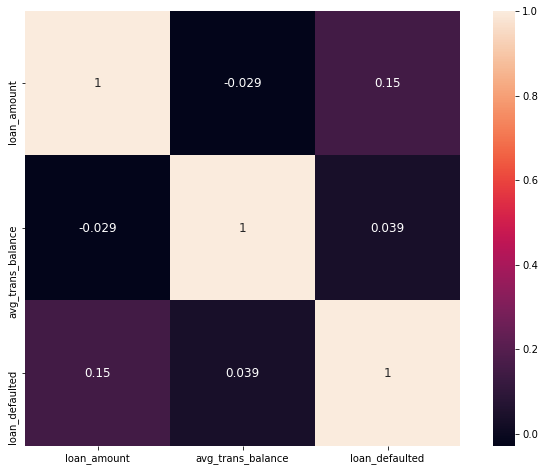

In [24]:
# check corrleation
print(df_model.shape)#, df_model.columns)

fig, ax = plt.subplots()#figsize=(20,15))
sns.heatmap(df_model.corr(),
            ax = ax,
            annot=True,
            square=True,
            annot_kws={'fontsize': 12}
            )

plt.show();

0.0    751
1.0     76
Name: loan_defaulted, dtype: int64


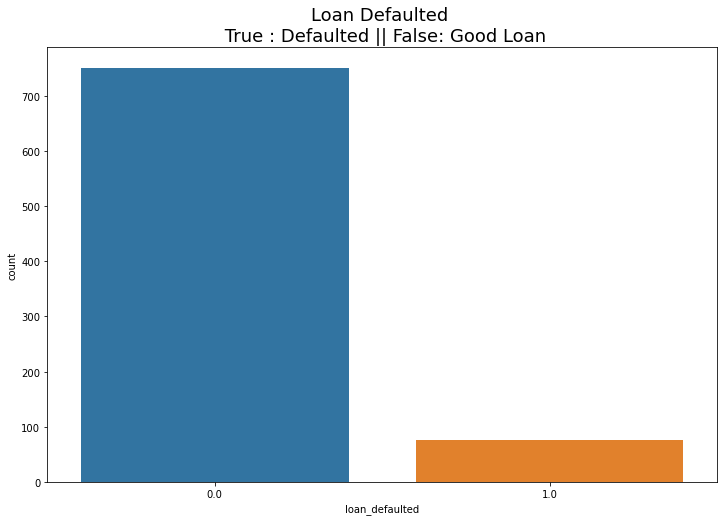

In [25]:
# visualize how many defaulted in loan
print(df_model['loan_defaulted'].value_counts())

sns.countplot('loan_defaulted',data=df_model) ;
plt.title('Loan Defaulted \n True : Defaulted || False: Good Loan', fontsize = 18)
plt.show();

In [26]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827 entries, 0 to 826
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   loan_amount        827 non-null    float64 
 1   acc_freq           827 non-null    object  
 2   district_name      827 non-null    object  
 3   disp_type          827 non-null    object  
 4   sex                827 non-null    object  
 5   age_group          827 non-null    category
 6   card_type          170 non-null    object  
 7   avg_trans_balance  787 non-null    float64 
 8   loan_defaulted     827 non-null    float64 
dtypes: category(1), float64(3), object(5)
memory usage: 99.1+ KB


### Column Tranformation

In [27]:
# Splitting the trainand set using stratify

X = df_model.iloc[:, :-1]
y = df_model.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))


(620, 8) (207, 8) (620,) (207,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [28]:
#separate into num and cat columns
def num_cat_separation(d):
    num_cols = []
    cat_cols = []
    for c in d.columns:
        if d[c].dtype == 'object': # if it is an object
            cat_cols.append(c)
        else:
            num_cols.append(c)
    return num_cols, cat_cols

num_cols, cat_cols = num_cat_separation(df_model)
print('num_col are ', num_cols)
print('cat-col are ', cat_cols)

num_col are  ['loan_amount', 'age_group', 'avg_trans_balance', 'loan_defaulted']
cat-col are  ['acc_freq', 'district_name', 'disp_type', 'sex', 'card_type']


In [29]:
#https://www.kdnuggets.com/2020/06/simplifying-mixed-feature-type-preprocessing-scikit-learn-pipelines.html

#num_val
num_transform = Pipeline( steps= [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])
#cat_val
cat_transform = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy='constant', fill_value= 'missing_val')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

#column transfomer
pre_proc = ColumnTransformer(
    transformers = [
        ('num', num_transform, make_column_selector(dtype_include = 'float64')),
        ('cat', cat_transform, make_column_selector(dtype_include='object'))
    ])

# fit and transform
pre_proc.fit(pd.DataFrame(X_train))
X_train = pre_proc.transform(X_train)
X_test  = pre_proc.transform(X_test)
X_train = X_train.toarray() # change sparse matrix
X_test  = X_test.toarray() # change sparse matrix

print('X_train is of type',type(X_train))

print(X_train.shape, X_test.shape)


X_train is of type <class 'numpy.ndarray'>
(620, 89) (207, 89)


In [30]:
y[:10]

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    1.0
9    0.0
Name: loan_defaulted, dtype: float64

# ML Modeling

### Classification Model

In [31]:
# SMORE
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Before applying SM no of 0 --', sum(y_train == 0))
print('Before applying SM no of 1 -- ',sum(y_train == 1))

sm = SMOTE()
X_train_sm , y_train_sm = sm.fit_sample(X_train, y_train)

print(X_train_sm.shape, X_test.shape, y_train_sm.shape, y_test.shape)
print('After applying SM no of 0 --', sum(y_train_sm == 0))
print('After applying SM no of 1 --',sum(y_train_sm == 1))

(620, 89) (207, 89) (620,) (207,)
Before applying SM no of 0 -- 563
Before applying SM no of 1 --  57
(1126, 89) (207, 89) (1126,) (207,)
After applying SM no of 0 -- 563
After applying SM no of 1 -- 563


Train Accuracy Score - 0.7080645161290322
**************************************************
Test Accuracy Score - 0.7004830917874396
**************************************************
ROC score of test is  0.7583986562150056
**************************************************
ROC score of train is  0.8284877379950764
**************************************************
tn, fp, fn, tp [[132   6]
 [ 56  13]]
              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81       138
         1.0       0.68      0.19      0.30        69

    accuracy                           0.70       207
   macro avg       0.69      0.57      0.55       207
weighted avg       0.70      0.70      0.64       207



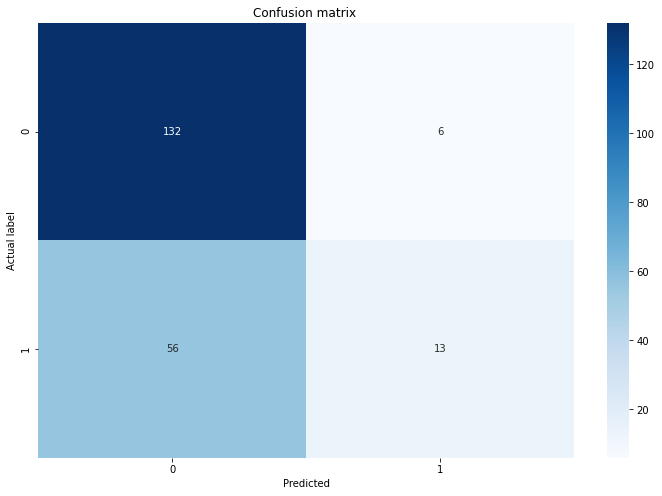

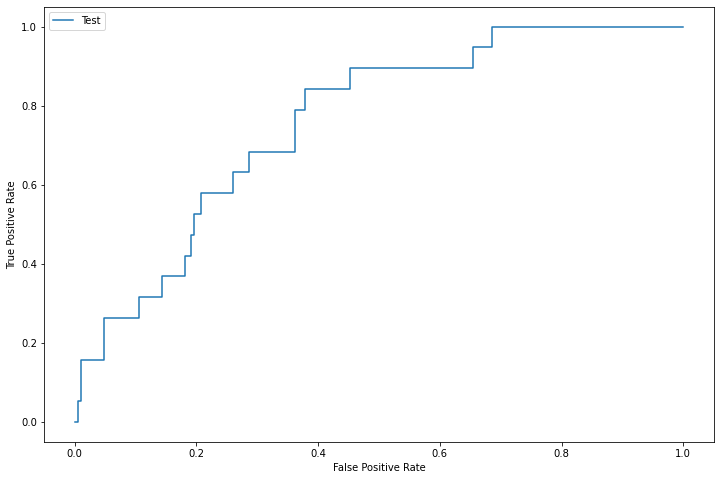

In [32]:
# base line model of logistic classification

clf_lr = LogisticRegression(penalty= 'l2', C=0.1)
clf_lr.fit(X_train_sm, y_train_sm.ravel())

# prediction
pred_clf_lr_tr = clf_lr.predict(X_train)
pred_clf_lr_te = clf_lr.predict(X_test)

print('Train Accuracy Score -', accuracy_score(pred_clf_lr_tr, y_train))
print('*'*50)
print('Test Accuracy Score -', accuracy_score(pred_clf_lr_te, y_test))
print('*'*50)
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

pred_proba_te = clf_lr.predict_log_proba(X_test)
pred_proba_te = pred_proba_te[:, 1] # taking only the first one
roc_te = roc_auc_score(y_test, pred_proba_te)
print('ROC score of test is ', roc_te)

print('*'*50)
pred_proba_tr = clf_lr.predict_log_proba(X_train)
pred_proba_tr = pred_proba_tr[:, 1] # taking only the first one
roc_tr = roc_auc_score(y_train, pred_proba_tr)
print('ROC score of train is ', roc_tr)

print('*'*50)

conf_matrix_lr_te = confusion_matrix(pred_clf_lr_te , y_test )
print('tn, fp, fn, tp', confusion_matrix(pred_clf_lr_te, y_test ))

print(classification_report(pred_clf_lr_te,y_test))

sns.heatmap(conf_matrix_lr_te, annot=True, fmt = 'd', cmap="Blues")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted')
plt.show()



lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, pred_proba_te)
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Decision Tree

In [33]:
np.isnan(y_test.any())

False

In [48]:
#decision tree

clf_dt = tree.DecisionTreeClassifier(
                criterion='entropy',
                random_state=42,
                max_depth=5,
                min_samples_leaf=5
                )

clf_dt.fit(X_train_sm, y_train_sm.ravel())

# prediction
pred_clf_dt_tr = clf_dt.predict(X_train_sm)
pred_clf_dt_te = clf_dt.predict(X_test)

print('Train Accuracy Score -', accuracy_score(pred_clf_dt_tr, y_train_sm))
print('*'*50)
print('Test Accuracy Score -', accuracy_score(pred_clf_dt_te, y_test))
print('*'*50)
print('*'*50)

tree.plot_tree(clf_dt)
print('*'*50)
print('*'*50)

# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

pred_proba_dt_te = clf_dt.predict_log_proba(X_test)
pred_proba__dt_te = pred_proba_dt_te[:, 1] # taking only the first one


roc_dt_te = roc_auc_score(y_test, pred_proba_dt_te)
print('ROC score of test is ', roc_dt_te)

print('*'*50)
pred_proba_dt_tr = clf_dt.predict_log_proba(X_train_sm)
pred_proba_dt_tr = pred_proba_dt_tr[:, 1] # taking only the first one
roc_dt_tr = roc_auc_score(y_train_sm, pred_proba_dt_tr)
print('ROC score of train is ', roc_dt_tr)

print('*'*50)

conf_matrix_dt_te = confusion_matrix(pred_clf_dt_te , y_test )
print('tn, fp, fn, tp', confusion_matrix(pred_clf_dt_te, y_test ))

print(classification_report(pred_clf_dt_te,y_test))

sns.heatmap(conf_matrix_dt_te, annot=True, fmt = 'd', cmap="Blues")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted')
plt.show()



lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, pred_proba_dt_te)
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Train Accuracy Score - 0.7673179396092362
**************************************************
Test Accuracy Score - 0.5555555555555556
**************************************************
**************************************************
**************************************************
**************************************************
/Users/khan_m_a/opt/anaconda3/envs/cv/lib/python3.7/site-packages/sklearn/tree/_classes.py:973: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [49]:
pred_proba_dt_te[:10]

array([[-0.99340804, -0.46253161],
       [ 0.        ,        -inf],
       [ 0.        ,        -inf],
       [ 0.        ,        -inf],
       [ 0.        ,        -inf],
       [ 0.        ,        -inf],
       [-0.99340804, -0.46253161],
       [-0.99340804, -0.46253161],
       [ 0.        ,        -inf],
       [-0.13926207, -2.04022083]])

[Text(418.5, 380.52, 'X[81] <= 0.5\nentropy = 1.0\nsamples = 1126\nvalue = [563, 563]'),
 Text(334.8, 271.8, 'X[88] <= 0.008\nentropy = 0.991\nsamples = 1012\nvalue = [449, 563]'),
 Text(167.4, 163.07999999999998, 'X[0] <= 0.2\nentropy = 0.17\nsamples = 119\nvalue = [116, 3]'),
 Text(83.7, 54.360000000000014, 'entropy = 0.0\nsamples = 81\nvalue = [81, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'entropy = 0.398\nsamples = 38\nvalue = [35, 3]'),
 Text(502.20000000000005, 163.07999999999998, 'X[0] <= -0.811\nentropy = 0.953\nsamples = 893\nvalue = [333, 560]'),
 Text(418.5, 54.360000000000014, 'entropy = 0.831\nsamples = 118\nvalue = [87, 31]'),
 Text(585.9, 54.360000000000014, 'entropy = 0.902\nsamples = 775\nvalue = [246, 529]'),
 Text(502.20000000000005, 271.8, 'entropy = 0.0\nsamples = 114\nvalue = [114, 0]')]

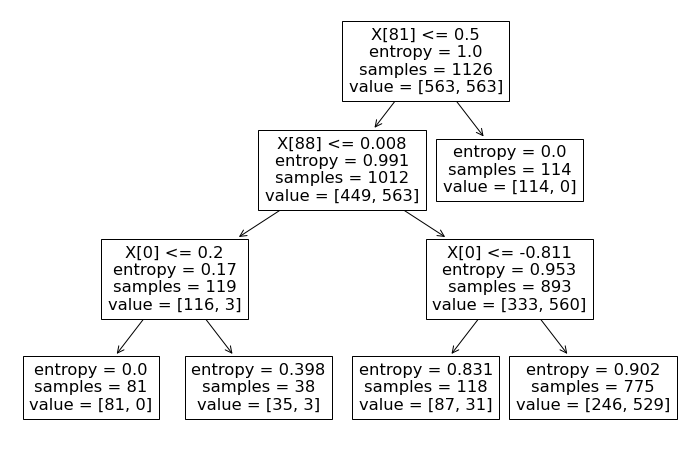

In [45]:
tree.plot_tree(clf_dt)

### Random Forest

In [ ]:
# Random Forest Model

clf_rf = RandomForestClassifier(
                             bootstrap= False,
                            max_depth= 3, # expand it the tree reaches leaf 80,
                            #max_features= 3, # no. of features when looking for the best feature.
                            min_samples_leaf= 5, # min sample to be a leaf
                            min_samples_split= 10, # min samples of leaf required to split an internal node.
                            n_estimators= 100,
                            max_features=  0.5, #'log2', # 'auto', “sqrt”, “log2”
                            max_samples= 0.5,
                            random_state=42)
clf_rf.fit(X_train, y_train)



# Predictions from test dataset
clf_rf_pred = clf_rf.predict(X_test)
clf_rf_proba = clf_rf.predict_proba(X_test)
clf_rf_proba = clf_rf_proba[:, 1]
print(clf_rf_pred[:10], '\n', clf_rf_proba[:10])

roc_score_rf = roc_auc_score(y_test,clf_rf_proba )
print('AUC score of Test :',roc_score_rf)
print('*'*100)

# 
# Predictions from train dataset
clf_rf_pred_tr = clf_rf.predict(X_train)
clf_rf_proba_tr = clf_rf.predict_proba(X_train)
clf_rf_proba_tr = clf_rf_proba_tr[:, 1]
print(clf_rf_pred_tr[:10], '\n', clf_rf_proba_tr[:10])

roc_score_rf_tr = roc_auc_score(y_train,clf_rf_proba_tr )
print('AUC score of Train :',roc_score_rf_tr)

In [ ]:
# ROC score




In [ ]:
# predict test accurace
# confusion matrix on Test
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''


conf_matrix_rf_te = confusion_matrix(clf_rf_pred , y_test )
print('tn, fp, fn, tp', confusion_matrix(clf_rf_pred, y_test ))

print(classification_report(clf_rf_pred,y_test))

# clf_rf_proba = clf_rf_proba[:, 1] # taking only the first one
roc_rf_te = roc_auc_score(y_test, clf_rf_proba)
print('ROC score of test is ', roc_rf_te)

sns.heatmap(conf_matrix_rf_te, annot=True, fmt = 'd', cmap="Blues")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted')
plt.show()

# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, clf_rf_proba)
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# SMOTE
SMOTE or Synthetic Minority Oversampling Technique is a popular algorith to creates synthetic observation fo the Minority class.

SVMSMOTE : Variance of SMOTE using SV Algo.
SMOTETomek : Combines undersampling and oversampling using tomek link(Tomeck links removes unwanted pos and neg classes)

In [ ]:
# SMORE
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Before applying SM no of 0 --', sum(y_train == 0))
print('Before applying SM no of 1 -- ',sum(y_train == 1))

sm = SMOTE()
X_train_sm , y_train_sm = sm.fit_sample(X_train, y_train)

print(X_train_sm.shape, X_test.shape, y_train_sm.shape, y_test.shape)
print('After applying SM no of 0 --', sum(y_train_sm == 0))
print('After applying SM no of 1 --',sum(y_train_sm == 1))

In [ ]:
# Random Forest Model

clf_rf_sm = RandomForestClassifier(n_estimators=1000,
                            max_depth= 5,
                             random_state=42)
clf_rf_sm.fit(X_train_sm, y_train_sm)

# Predictions from test set
clf_rf_pred_sm = clf_rf_sm.predict(X_test)
clf_rf_proba_sm = clf_rf_sm.predict_proba(X_test)
clf_rf_proba_sm = clf_rf_proba_sm[:, 1]
print(clf_rf_pred_sm[:10], '\n', clf_rf_proba_sm[:10])

# ROC score
roc_score_rf_sm = roc_auc_score(y_test,clf_rf_proba_sm )
print('AUC score for test is :',roc_score_rf_sm)
print('*'*50)

# Predictions from train
clf_rf_pred_sm_tr = clf_rf_sm.predict(X_train)
clf_rf_proba_sm_tr = clf_rf_sm.predict_proba(X_train)
clf_rf_proba_sm_tr = clf_rf_proba_sm_tr[:, 1]
print(clf_rf_pred_sm_tr[:10], '\n', clf_rf_proba_sm_tr[:10])

# ROC score
roc_score_rf_sm_tr = roc_auc_score(y_train,clf_rf_proba_sm_tr )
print('AUC score for train is :',roc_score_rf_sm_tr)


In [ ]:
# predict test accurace
# confusion matrix on Test
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''


conf_matrix_rf_te_sm = confusion_matrix(clf_rf_pred_sm , y_test )
print('tn, fp, fn, tp', confusion_matrix(clf_rf_pred_sm, y_test ))

print(classification_report(clf_rf_pred_sm,y_test))

# clf_rf_proba = clf_rf_proba[:, 1] # taking only the first one
roc_rf_te_sm = roc_auc_score(y_test, clf_rf_proba_sm)
print('ROC score of test is ', roc_rf_te_sm)

sns.heatmap(conf_matrix_rf_te_sm, annot=True, fmt = 'd', cmap="Blues")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted')
plt.show()

# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/




lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, clf_rf_proba_sm)
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# Grid Search Random Forest

In [ ]:
# define mode
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

rf_gs = RandomForestClassifier(random_state=42)

from pprint import pprint
print(rf_gs.get_params())

grid_search_param = {
                'bootstrap': [True, False], 
                #'ccp_alpha': 0.0, 
                #'class_weight': None, 
                #'criterion': 'gini', 
                'max_depth': [80, 90, 100, 120], 
                'max_features':  [2, 3, 4], 
                #'max_leaf_nodes': None, 
                # 'max_samples': None, 
                #'min_impurity_decrease': 0.0, 
                # 'min_impurity_split': None, 
                'min_samples_leaf': [1, 3, 5],
                'min_samples_split': [8, 10, 12],
                # 'min_weight_fraction_leaf': 0.0, 
                'n_estimators': [100, 250, 500, 1000],
                # 'n_jobs': None, 
                # 'oob_score': False, 
                # 'random_state': 42, 
                # 'verbose': 0, 
                # 'warm_start': False
                }


In [ ]:
# instantiate the grid

grid_search = GridSearchCV(estimator=  rf_gs, 
                            param_grid= grid_search_param,
                            cv = 5, verbose=2)

grid_search.fit(X_train_sm, y_train_sm)

# no. of combinations to run = 2* 4 * 3* 3* 3* 4 = 768 combinations - almost 2 hours sim time

In [ ]:
grid_search.best_params_